#**AN AGENTIC CRYPTO MARKET**

---

##0.REFERENCE

##1.CONTEXT

**Introduction**

This Colab notebook is a controlled laboratory for a very specific question: when markets are noisy, fragmented, and full of execution frictions, can a decision-making agent operate in a disciplined, auditable, and economically coherent way—without relying on magical assumptions about perfect fills, instantaneous settlement, or costless transfers? The notebook answers that question by building a complete, synthetic crypto micro-world and then placing an “agent” inside it. The agent is not asked to predict prices. It is not asked to discover alpha from historical data. It is asked to do something more operational, and often more difficult: continuously evaluate cross-exchange discrepancies, estimate whether they remain profitable once realistic costs are included, select a small number of trades under risk constraints, and survive the difference between what looks profitable in theory and what remains profitable after latency, slippage, fees, and partial fills.

The central design choice is synthetic construction. Crypto markets are appealing for studying fragmentation because multiple venues quote the same assets simultaneously, liquidity is uneven across exchanges, and microstructure details matter. But using real data would introduce unnecessary distractions: data cleaning, vendor biases, survivorship issues, and the ethical and practical implications of handling sensitive or proprietary information. This notebook avoids those issues by generating its own market: multiple assets, multiple exchanges, correlated shocks, occasional dislocations, and stylized order books. The objective is not to mimic any single real exchange perfectly; it is to create the conditions that make cross-venue decision-making nontrivial. If an agent performs well here, it does not prove that it will perform well in production. What it proves is something narrower and more important for early-stage research: that the logic of the decision loop is coherent, that cost modeling can be integrated into opportunity selection, and that performance can be diagnosed transparently.

The notebook’s structure is intentionally end-to-end. Many toy trading simulations stop at “we found spreads” and never confront the gritty part: can you actually execute the spread at the proposed size? Here, the opportunity scanner produces candidate arbitrages, but a separate execution engine determines what happens when the agent attempts the trade. This separation matters. It forces you to distinguish between three things that are often conflated in informal discussions: the observed spread (what quotes suggest), the expected net edge (what a model estimates after costs), and the realized outcome (what fills actually deliver). In real markets, that triangle is where most naïve strategies break. Spreads are visible, edges are estimated, and outcomes are earned—often inconsistently. By building the full loop, the notebook makes it possible to analyze where and why the loop fails: does the agent chase thin edges that collapse under fees? Does it size too aggressively into shallow depth? Does latency drift destroy the edge? Or does a conservative policy leave profit on the table?

A second design choice is to treat “risk” as an explicit gate, not a footnote. Arbitrage sounds “safe” until it is not. Cross-exchange activity is exposed to operational failures, venue downtime, liquidity cliffs, and the unpleasant reality that the trade you want is not always the trade you can get. Even in a synthetic environment, the notebook enforces constraints that resemble professional practice: maximum drawdown limits, daily loss caps, position sizing rules tied to available cash, and minimum edge thresholds. These constraints do not guarantee safety. They do something more honest: they make the system’s assumptions legible. A strategy that only works by repeatedly taking large positions into small spreads is not “arbitrage” in any meaningful sense—it is leveraged speculation in disguise. By requiring the agent to justify trade size against expected edge and to respect simple limits, the notebook shifts the focus from “can we make the curve go up” to “can we act like a sensible risk-managed operator.”

The third design choice is agentic control, but in a constrained and auditable form. In this notebook, the agent is asked to produce structured decisions: which trades to place, where to buy and sell, and how large to trade. The agent is not allowed to execute arbitrary code. It cannot silently change parameters. It is forced into a JSON response format and given explicit rules: trade only if net edge exceeds a threshold, avoid low-confidence opportunities, prefer fewer high-quality trades to a flood of marginal ones, and scale down in stress. In other words, the agent is treated as a policy engine with guardrails—not as an omniscient oracle. This is important for two reasons. First, it makes the decisions inspectable. You can compare the agent’s proposed trades against the scanner’s estimates and the risk gate’s acceptance criteria. Second, it turns the notebook into a testbed for policy design. You can swap the LLM for a hand-coded baseline, or adjust the prompt to emphasize caution, aggressiveness, diversification, or cost sensitivity, and then observe how that changes performance in the same environment.

The heart of the notebook is the synthetic market itself. Prices evolve through correlated shocks so that assets do not move independently, reflecting the reality that market-wide risk factors often dominate micro-movements. There is mean reversion to avoid unbounded drift, occasional jumps to simulate news-like events, and exchange-specific deviations that create the possibility of arbitrage. Crucially, those deviations are not constant: they have persistence and randomness. This matters because a “static premium” is too easy. Real mispricings are episodic and uncertain. The notebook therefore creates an environment where opportunities appear, fade, and sometimes mislead. That uncertainty is essential if you want to evaluate whether the agent is reasoning about fragility rather than mechanically harvesting deterministic spreads.

Execution frictions are equally central. A strategy that looks profitable before costs is almost always trivial. The notebook makes costs unavoidable. Fees are applied on both legs. Slippage increases with size relative to volume and is capped to reflect the idea that extreme slippage implies the trade simply could not be done at that size. Latency is sampled and used both in execution (price drift during delay) and in scanning (a volatility-based latency risk penalty). Partial fills can occur if depth is insufficient, and trades can fail outright if an exchange is unavailable. This is not a perfect microstructure simulator, but it creates the right qualitative pressures: edges are fragile, and careless sizing converts apparent arbitrage into realized loss.

The notebook ends with two forms of evaluation: quantitative analytics and qualitative reflection. The analytics are a set of practical diagnostics: equity curve, trade-by-trade PnL, cumulative net PnL, cost breakdown, PnL by asset, and opportunity flow. These plots help you locate failure modes quickly. For example, if gross PnL looks healthy but net PnL is weak, costs are the culprit. If losses cluster in a particular asset, the agent may be overconfident about that asset’s liquidity. If drawdowns coincide with high trade frequency, the system may be chasing noise. Alongside the analytics, the notebook includes an agent post-mortem: a structured summary of what it did and why, and what it would change. This second layer is not “truth,” but it is useful for prompt iteration. It allows you to treat the agent as a policy that can be tuned: you are not just evaluating outcomes, you are learning how the decision policy behaves under pressure.

Taken together, the notebook is a didactic companion focused on mechanisms. It shows how fragmentation, microstructure, and risk interact in a realistic decision loop. It does not claim market validity; it claims conceptual clarity. It is the kind of environment you want before touching production data: a place to break your assumptions cheaply, to discover where the edge disappears, and to learn whether an agent can behave like a disciplined operator when the difference between “spread” and “profit” is a minefield of costs. If you read it in that spirit, it becomes more than a toy: it becomes a framework for thinking, testing, and iterating on agentic trading policies under explicit constraints.


##2.LIBRARIES AND ENVIRONMENT

In [1]:
# ══════════════════════════════════════════════════════════════════════
# CELL 1: INSTALLATION & CONFIGURATION
# ══════════════════════════════════════════════════════════════════════

!pip install -q openai numpy pandas matplotlib seaborn scipy

import os, json, time, uuid, hashlib, logging
from datetime import datetime, timedelta
from dataclasses import dataclass, field, asdict
from typing import Dict, List, Optional, Tuple, Any
from enum import Enum
from copy import deepcopy
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from scipy.linalg import cholesky

from google.colab import userdata
from openai import OpenAI

# ── API Setup ──
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)
MODEL = "gpt-5.2"

# ── Global Config ──
np.random.seed(42)
pd.set_option('display.float_format', '{:.6f}'.format)
sns.set_theme(style='darkgrid', palette='husl')

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s | %(levelname)s | %(message)s')
logger = logging.getLogger('ArbitrageAgent')

print("✅ Environment ready. Model:", MODEL)

✅ Environment ready. Model: gpt-5.2


In [2]:
# ══════════════════════════════════════════════════════════════════════
# CELL 2: MARKET MICROSTRUCTURE & EXCHANGE DEFINITIONS
# ══════════════════════════════════════════════════════════════════════

class OrderSide(Enum):
    BUY = 'buy'
    SELL = 'sell'

class OrderStatus(Enum):
    PENDING = 'pending'
    FILLED = 'filled'
    PARTIAL = 'partial'
    REJECTED = 'rejected'
    CANCELLED = 'cancelled'

class SettlementStatus(Enum):
    UNSETTLED = 'unsettled'
    IN_TRANSIT = 'in_transit'
    SETTLED = 'settled'
    FAILED = 'failed'

@dataclass
class ExchangeConfig:
    name: str
    maker_fee_bps: float
    taker_fee_bps: float
    withdrawal_fee_pct: float
    withdrawal_flat_usd: float
    min_order_usd: float
    max_order_usd: float
    latency_ms_mean: float
    latency_ms_std: float
    slippage_coefficient: float    # impact = coeff * sqrt(order_size / minute_volume)
    uptime_probability: float
    settlement_time_minutes: float
    margin_requirement: float
    maintenance_margin: float
    max_leverage: float
    spread_multiplier: float

@dataclass
class CryptoAsset:
    symbol: str
    name: str
    base_price: float
    daily_volume_usd: float
    volatility_annual: float
    mean_reversion_speed: float
    jump_intensity: float          # Poisson jumps per day
    jump_mean: float
    jump_std: float
    network_confirm_minutes: float

# ── 5 Exchanges ──
EXCHANGES = {
    'nexus':   ExchangeConfig('Nexus Prime',     8, 15, 0.0005,  5, 50, 500000,  12,  4, 0.08, 0.998,  2, 0.05, 0.025, 20, 1.0),
    'vortex':  ExchangeConfig('Vortex Global',   5, 12, 0.0008,  8, 25, 750000,  25, 10, 0.12, 0.995,  5, 0.10, 0.050, 10, 1.2),
    'phantom': ExchangeConfig('Phantom DEX',     12, 25, 0.0003,  2,100, 300000,  45, 20, 0.15, 0.990, 10, 0.15, 0.075,  5, 1.8),
    'citadel': ExchangeConfig('Citadel Markets',  3, 10, 0.0010, 12, 10,1000000,   8,  2, 0.06, 0.999,  1, 0.03, 0.015, 50, 0.8),
    'drift':   ExchangeConfig('Drift Finance',   15, 30, 0.0002,  1,200, 200000,  60, 25, 0.20, 0.985, 15, 0.20, 0.100,  3, 2.2),
}

# ── 10 Crypto Assets ──
ASSETS = {
    'BTC':  CryptoAsset('BTC',  'Bitcoin',     67500, 28e9, 0.65, 0.02, 0.3,-0.001, 0.035, 30),
    'ETH':  CryptoAsset('ETH',  'Ethereum',     3750, 15e9, 0.78, 0.03, 0.4,-0.002, 0.042, 12),
    'SOL':  CryptoAsset('SOL',  'Solana',        178,3.2e9, 0.95, 0.05, 0.6, 0.000, 0.055,  1),
    'BNB':  CryptoAsset('BNB',  'BNB',           610,1.8e9, 0.72, 0.04, 0.3,-0.001, 0.038,  5),
    'XRP':  CryptoAsset('XRP',  'Ripple',       0.62,2.1e9, 0.88, 0.06, 0.5, 0.001, 0.048,  4),
    'ADA':  CryptoAsset('ADA',  'Cardano',      0.48,0.8e9, 0.92, 0.07, 0.5, 0.000, 0.052, 10),
    'AVAX': CryptoAsset('AVAX', 'Avalanche',    38.5,0.6e9, 1.05, 0.06, 0.7, 0.001, 0.060,  2),
    'DOGE': CryptoAsset('DOGE', 'Dogecoin',    0.165,1.5e9, 1.15, 0.08, 0.8, 0.002, 0.070, 10),
    'LINK': CryptoAsset('LINK', 'Chainlink',    18.2,0.9e9, 0.90, 0.05, 0.4,-0.001, 0.045,  5),
    'DOT':  CryptoAsset('DOT',  'Polkadot',    7.85, 0.5e9, 0.98, 0.06, 0.5, 0.000, 0.050,  8),
}

print(f"✅ {len(EXCHANGES)} exchanges × {len(ASSETS)} assets = {len(EXCHANGES)*len(ASSETS)} markets")
print("\nExchange profiles:")
for eid, ex in EXCHANGES.items():
    print(f"  {ex.name:20s} │ Taker: {ex.taker_fee_bps:2.0f}bps │ "
          f"Slippage: {ex.slippage_coefficient:.2f} │ "
          f"Latency: {ex.latency_ms_mean:.0f}±{ex.latency_ms_std:.0f}ms │ "
          f"Margin: {ex.margin_requirement:.0%}")

✅ 5 exchanges × 10 assets = 50 markets

Exchange profiles:
  Nexus Prime          │ Taker: 15bps │ Slippage: 0.08 │ Latency: 12±4ms │ Margin: 5%
  Vortex Global        │ Taker: 12bps │ Slippage: 0.12 │ Latency: 25±10ms │ Margin: 10%
  Phantom DEX          │ Taker: 25bps │ Slippage: 0.15 │ Latency: 45±20ms │ Margin: 15%
  Citadel Markets      │ Taker: 10bps │ Slippage: 0.06 │ Latency: 8±2ms │ Margin: 3%
  Drift Finance        │ Taker: 30bps │ Slippage: 0.20 │ Latency: 60±25ms │ Margin: 20%


##3.SYNTHETIC PRICE ENGINE

###3.1.OVERVIEW

**Cell 3 — SyntheticPriceEngine: generating a fragmented market with dislocations**

This cell builds the market generator, the component that produces time-evolving quotes for every asset on every exchange. The purpose is to create a world where cross-exchange discrepancies exist often enough to study them, but not so deterministically that the exercise becomes trivial. To do that, the engine combines several mechanisms. It introduces correlated shocks across assets so that market-wide moves exist, and it includes mean reversion to prevent unbounded drift away from plausible ranges. It may also incorporate rare jump events to mimic abrupt regime changes. The most important feature is exchange-specific deviation: each venue’s quoted price is a distorted version of a latent “true” price, with both persistent bias and temporary stochastic deviation. On top of that, occasional dislocation events deliberately push one exchange away from others, manufacturing the kind of transient dispersion that makes arbitrage conceivable. The engine also constructs spreads and stylized order book depth so that liquidity is limited and execution becomes size-dependent. In effect, this cell supplies the “physics” of the simulated market. It does not aim to be a perfect microstructure replica; it aims to produce the right qualitative challenges: dispersion, noise, liquidity constraints, and unpredictability about how long an edge will persist.


###3.2.CODE AND IMPLEMENTATION

In [32]:
# ══════════════════════════════════════════════════════════════════════
# CELL 3: SYNTHETIC PRICE ENGINE
# ══════════════════════════════════════════════════════════════════════

class SyntheticPriceEngine:

    def __init__(self, assets: Dict[str, CryptoAsset],
                 exchanges: Dict[str, ExchangeConfig]):
        self.assets = assets
        self.exchanges = exchanges
        self.asset_list = list(assets.keys())
        self.n_assets = len(self.asset_list)

        self.corr_matrix = self._build_correlation_matrix()
        self.cholesky_L = cholesky(self.corr_matrix, lower=True)

        self.true_prices = {s: a.base_price for s, a in assets.items()}
        self.log_prices  = {s: np.log(a.base_price) for s, a in assets.items()}

        # ── STRUCTURAL BIASES: persistent premium/discount per exchange-asset ──
        rng = np.random.RandomState(99)
        self.structural_bias = {
            eid: {s: rng.normal(0, 0.0030) for s in self.asset_list}
            for eid in exchanges
        }

        # ── Stochastic deviation init ──
        rng2 = np.random.RandomState(77)
        self.exchange_deviations = {
            eid: {s: rng2.normal(0, 0.0015) for s in self.asset_list}
            for eid in exchanges
        }

        self.tick = 0
        self.dt = 1 / (24 * 60)
        self.price_history = []

    def _build_correlation_matrix(self) -> np.ndarray:
        n = self.n_assets
        corr = np.eye(n)
        groups = {
            'majors': ['BTC', 'ETH'],
            'l1':     ['SOL', 'ADA', 'AVAX', 'DOT'],
            'defi':   ['LINK'],
            'meme':   ['DOGE'],
            'legacy': ['XRP', 'BNB'],
        }
        for i, si in enumerate(self.asset_list):
            for j, sj in enumerate(self.asset_list):
                if i == j:
                    continue
                base = 0.55
                for g, members in groups.items():
                    if si in members and sj in members:
                        base = 0.80 if g == 'majors' else 0.70
                if {si, sj} == {'BTC', 'ETH'}:
                    base = 0.87
                corr[i, j] = base
        eigvals = np.linalg.eigvalsh(corr)
        if eigvals.min() < 1e-6:
            corr += np.eye(n) * (1e-6 - eigvals.min())
        return corr

    def step(self) -> Dict[str, Dict[str, dict]]:
        self.tick += 1
        dt = self.dt

        z = self.cholesky_L @ np.random.standard_normal(self.n_assets)

        for idx, symbol in enumerate(self.asset_list):
            asset = self.assets[symbol]
            log_p = self.log_prices[symbol]
            log_p0 = np.log(asset.base_price)

            drift = -asset.mean_reversion_speed * (log_p - log_p0) * dt
            sigma = asset.volatility_annual / np.sqrt(365 * 24 * 60)
            diffusion = sigma * z[idx]

            jump = 0.0
            if np.random.poisson(asset.jump_intensity * dt) > 0:
                jump = np.random.normal(asset.jump_mean, asset.jump_std)

            self.log_prices[symbol] = log_p + drift + diffusion + jump
            self.true_prices[symbol] = np.exp(self.log_prices[symbol])

        market_data = {}
        for eid, exchange in self.exchanges.items():
            market_data[eid] = {}
            for symbol in self.asset_list:
                true_p = self.true_prices[symbol]
                asset  = self.assets[symbol]

                # ── AR(1) stochastic deviation ──
                prev = self.exchange_deviations[eid][symbol]
                innov_vol = 0.0018 * exchange.spread_multiplier
                new_dev = 0.96 * prev + np.random.normal(0, innov_vol)

                # Dislocation events (3% of ticks)
                if np.random.random() < 0.03:
                    new_dev += np.random.choice([-1, 1]) * np.random.exponential(0.004)

                self.exchange_deviations[eid][symbol] = new_dev

                # Total deviation
                total_dev = self.structural_bias[eid][symbol] + new_dev
                mid_price = true_p * (1 + total_dev)

                # ── TIGHT volume-scaled spreads ──
                log_vol = np.log10(max(asset.daily_volume_usd, 1e6) / 1e9)
                base_spread_bps = max(1.5, 4.0 - 2.0 * log_vol) * exchange.spread_multiplier
                noise_bps = np.random.exponential(base_spread_bps * 0.12)
                total_spread_bps = base_spread_bps + noise_bps
                half_spread = mid_price * total_spread_bps / 20000

                bid = mid_price - half_spread
                ask = mid_price + half_spread

                depth_usd = (asset.daily_volume_usd / (24 * 60)
                             ) * np.random.uniform(0.3, 1.5)
                book = self._make_book(bid, ask, depth_usd, mid_price)

                available = np.random.random() < exchange.uptime_probability

                market_data[eid][symbol] = {
                    'mid': mid_price, 'bid': bid, 'ask': ask,
                    'spread_bps': total_spread_bps,
                    'book': book, 'depth_usd': depth_usd,
                    'available': available, 'true_price': true_p,
                    'deviation_bps': total_dev * 10000,
                    'timestamp': self.tick,
                }

        self.price_history.append({
            'tick': self.tick,
            **{f'{s}_true': self.true_prices[s] for s in self.asset_list},
            **{f'{s}_{eid}_mid': market_data[eid][s]['mid']
               for eid in self.exchanges for s in self.asset_list}
        })
        return market_data

    def _make_book(self, bid, ask, depth_usd, mid, levels=5):
        tick = mid * 0.0001
        bids, asks = [], []
        for i in range(levels):
            d = depth_usd * np.random.exponential(0.3) * (1 + i * 0.5)
            bids.append({'price': bid - i * tick * np.random.uniform(1, 3),
                         'size_usd': d})
            asks.append({'price': ask + i * tick * np.random.uniform(1, 3),
                         'size_usd': d * np.random.uniform(0.7, 1.3)})
        return {'bids': bids, 'asks': asks}


# ── Initialize ──
engine = SyntheticPriceEngine(ASSETS, EXCHANGES)
for _ in range(30):
    engine.step()

print("✅ Price engine ready\n")

# ── Validate ──
pos_count, total_count = 0, 0
best_per_tick = []

for _ in range(50):
    md = engine.step()
    best = -9999
    for sym in ASSETS:
        eids = list(EXCHANGES.keys())
        for i, b in enumerate(eids):
            for j, s in enumerate(eids):
                if i == j:
                    continue
                raw = (md[s][sym]['bid'] - md[b][sym]['ask']) / md[b][sym]['ask'] * 10000
                total_count += 1
                if raw > 0:
                    pos_count += 1
                best = max(best, raw)
    best_per_tick.append(best)

pct = pos_count / max(total_count, 1)
ticks_w = sum(1 for b in best_per_tick if b > 0) / len(best_per_tick)

print(f"  Validation (50 ticks):")
print(f"    Positive raw spreads:   {pct:.1%} of all pairs")
print(f"    Ticks with ≥1 opp:      {ticks_w:.0%}")
print(f"    Best spread per tick:   mean={np.mean(best_per_tick):.1f}bps  max={np.max(best_per_tick):.1f}bps")

md = engine.step()
print(f"\n  Sample dispersion:")
for sym in ['BTC', 'ETH', 'SOL', 'DOGE']:
    mids = [md[eid][sym]['mid'] for eid in EXCHANGES]
    sprs = [md[eid][sym]['spread_bps'] for eid in EXCHANGES]
    disp = (max(mids) - min(mids)) / min(mids) * 10000
    print(f"    {sym:5s} │ Disp: {disp:>6.1f}bps │ Spreads: {min(sprs):.1f}-{max(sprs):.1f}bps")

✅ Price engine ready

  Validation (50 ticks):
    Positive raw spreads:   48.5% of all pairs
    Ticks with ≥1 opp:      100%
    Best spread per tick:   mean=442.5bps  max=611.7bps

  Sample dispersion:
    BTC   │ Disp:  225.6bps │ Spreads: 1.2-4.4bps
    ETH   │ Disp:  171.1bps │ Spreads: 1.7-3.9bps
    SOL   │ Disp:  234.6bps │ Spreads: 2.4-6.9bps
    DOGE  │ Disp:  265.8bps │ Spreads: 3.2-8.7bps


##4.EXECUTION ENGINE

###4.1.OVERVIEW

**Cell 4 — ExecutionEngine: simulating fills, latency, slippage, and costs**

This cell implements the harsh reality check: even if a scanner detects a spread, the world may not let you capture it at the proposed size or price. The execution engine takes a proposed order and simulates whether it fills, how much fills, and at what effective price after frictions. Latency is modeled as a random draw, and during that latency window the quoted prices can drift, representing the risk that the edge decays before your order lands. Liquidity is modeled via order book depth, so large orders must “walk the book,” paying progressively worse prices. Slippage is scaled with size relative to volume to enforce the empirical idea that impact grows nonlinearly. Fees are applied explicitly, and cross-exchange activity is penalized with withdrawal-like costs to represent settlement and transfer frictions. The core educational purpose of this cell is to separate “paper arbitrage” from executable arbitrage. It turns execution into an adversarial filter: optimistic sizing and marginal edges get punished. That is exactly what you want in a didactic simulation, because it forces disciplined thinking about net profitability rather than headline spread.


###4.2.CODE AND IMPLEMENTATION

In [29]:
# ══════════════════════════════════════════════════════════════════════
# CELL 4: EXECUTION ENGINE — Order Routing, Slippage, Settlement
# ══════════════════════════════════════════════════════════════════════

@dataclass
class Order:
    id: str = field(default_factory=lambda: str(uuid.uuid4())[:12])
    timestamp: int = 0
    exchange: str = ''
    symbol: str = ''
    side: OrderSide = OrderSide.BUY
    requested_usd: float = 0.0
    limit_price: Optional[float] = None
    status: OrderStatus = OrderStatus.PENDING
    filled_price: float = 0.0
    filled_usd: float = 0.0
    filled_qty: float = 0.0
    slippage_usd: float = 0.0
    fee_usd: float = 0.0
    latency_ms: float = 0.0
    settlement_status: SettlementStatus = SettlementStatus.UNSETTLED
    trade_group_id: str = ''

@dataclass
class ArbitrageTrade:
    id: str = field(default_factory=lambda: str(uuid.uuid4())[:8])
    timestamp: int = 0
    symbol: str = ''
    buy_exchange: str = ''
    sell_exchange: str = ''
    buy_order: Optional[Order] = None
    sell_order: Optional[Order] = None
    expected_spread_bps: float = 0.0
    expected_profit_usd: float = 0.0
    realized_profit_usd: float = 0.0
    total_fees_usd: float = 0.0
    total_slippage_usd: float = 0.0
    withdrawal_cost_usd: float = 0.0
    net_pnl_usd: float = 0.0
    settled: bool = False


class ExecutionEngine:
    """
    Realistic order execution:
    - Kyle's-lambda market impact (sqrt-scaling)
    - Latency-induced price drift
    - Order book walk for partial fills
    - Taker fees + withdrawal costs
    """

    def __init__(self, exchanges, assets):
        self.exchanges = exchanges
        self.assets = assets
        self.order_log: List[Order] = []
        self.trade_log: List[ArbitrageTrade] = []

    def execute_order(self, eid, symbol, side, size_usd, market_data, tick):
        ex = self.exchanges[eid]
        asset = self.assets[symbol]
        md = market_data[eid][symbol]

        order = Order(timestamp=tick, exchange=eid, symbol=symbol,
                      side=side, requested_usd=size_usd)

        # Availability & limits
        if not md['available']:
            order.status = OrderStatus.REJECTED
            self.order_log.append(order)
            return order
        if size_usd < ex.min_order_usd or size_usd > ex.max_order_usd:
            order.status = OrderStatus.REJECTED
            self.order_log.append(order)
            return order

        # Latency simulation
        latency = max(1.0, np.random.normal(ex.latency_ms_mean, ex.latency_ms_std))
        order.latency_ms = latency

        # Price drift during latency
        sigma_ms = asset.volatility_annual / np.sqrt(365*24*3600*1000)
        drift = md['mid'] * sigma_ms * np.sqrt(latency) * np.random.standard_normal()

        # Walk order book
        book_side = md['book']['asks'] if side == OrderSide.BUY else md['book']['bids']
        filled_usd, remaining = 0.0, size_usd
        for level in book_side:
            fill = min(remaining, level['size_usd'])
            filled_usd += fill
            remaining -= fill
            if remaining <= 0:
                break

        if filled_usd < size_usd * 0.5:
            order.status = OrderStatus.REJECTED
            self.order_log.append(order)
            return order

        # Market impact (Kyle's lambda)
        minute_vol = asset.daily_volume_usd / 1440
        impact = ex.slippage_coefficient * np.sqrt(size_usd / minute_vol)
        impact = min(impact, 0.02)

        if side == OrderSide.BUY:
            exec_price = md['ask'] * (1 + impact) + drift
        else:
            exec_price = md['bid'] * (1 - impact) + drift

        exec_price = np.clip(exec_price, md['mid']*0.95, md['mid']*1.05)
        filled_qty = filled_usd / exec_price

        # Slippage
        ideal = md['ask'] if side == OrderSide.BUY else md['bid']
        slippage_usd = abs(exec_price - ideal) * filled_qty

        # Fee
        fee_usd = filled_usd * ex.taker_fee_bps / 10000

        order.status = (OrderStatus.FILLED if filled_usd >= size_usd * 0.95
                        else OrderStatus.PARTIAL)
        order.filled_price = exec_price
        order.filled_usd = filled_usd
        order.filled_qty = filled_qty
        order.slippage_usd = slippage_usd
        order.fee_usd = fee_usd
        self.order_log.append(order)
        return order

    def execute_arbitrage(self, symbol, buy_eid, sell_eid, size_usd,
                          market_data, tick, expected_bps):
        trade = ArbitrageTrade(
            timestamp=tick, symbol=symbol,
            buy_exchange=buy_eid, sell_exchange=sell_eid,
            expected_spread_bps=expected_bps)

        buy_o  = self.execute_order(buy_eid,  symbol, OrderSide.BUY,  size_usd, market_data, tick)
        sell_o = self.execute_order(sell_eid, symbol, OrderSide.SELL, size_usd, market_data, tick)
        buy_o.trade_group_id = sell_o.trade_group_id = trade.id
        trade.buy_order, trade.sell_order = buy_o, sell_o

        if buy_o.status in (OrderStatus.REJECTED, OrderStatus.CANCELLED):
            return trade
        if sell_o.status in (OrderStatus.REJECTED, OrderStatus.CANCELLED):
            trade.net_pnl_usd = -buy_o.fee_usd
            return trade

        min_qty = min(buy_o.filled_qty, sell_o.filled_qty)
        gross = min_qty * (sell_o.filled_price - buy_o.filled_price)
        fees  = buy_o.fee_usd + sell_o.fee_usd
        slip  = buy_o.slippage_usd + sell_o.slippage_usd

        buy_ex = self.exchanges[buy_eid]
        withdrawal = size_usd * buy_ex.withdrawal_fee_pct + buy_ex.withdrawal_flat_usd

        trade.expected_profit_usd = size_usd * expected_bps / 10000
        trade.realized_profit_usd = gross
        trade.total_fees_usd = fees
        trade.total_slippage_usd = slip
        trade.withdrawal_cost_usd = withdrawal
        trade.net_pnl_usd = gross - fees - withdrawal

        self.trade_log.append(trade)
        return trade


execution_engine = ExecutionEngine(EXCHANGES, ASSETS)
print("✅ Execution engine ready")
print("   Models: Kyle's-lambda slippage, latency drift, book walk, taker fees, withdrawal costs")

✅ Execution engine ready
   Models: Kyle's-lambda slippage, latency drift, book walk, taker fees, withdrawal costs


##5.PORTFOLIO AND RISK MANAGEMENT

###5.1.OVERVIEW

**Cell 5 — PortfolioState and RiskManager: constraints, accounting, and survivability**

This cell defines how the simulated trader exists inside the environment. Portfolio state tracks cash, balances by exchange, cumulative costs, realized profit and loss, and an equity curve over time. The risk manager is the gatekeeper that decides whether a proposed trade is allowed. The key is that approval is not based on excitement; it is based on survival rules. The risk manager enforces position sizing limits relative to cash, ensures the buy-side venue has sufficient balance, and blocks trading once drawdown or daily loss limits are breached. It also rejects trades whose expected edge is below a minimum threshold, preventing the agent from churning the account on noise. The deeper function of this cell is governance: it defines a contract between the decision policy and the system. The policy may want to trade, but the system decides whether it may. This arrangement mirrors real institutional practice where risk limits, compliance, and capital controls constrain discretionary action. In a learning setting, it is also diagnostically powerful: when the agent proposes a trade that is rejected, you learn something about misalignment between policy and constraints.


###5.2.CODE AND IMPLEMENTATION

In [30]:
# ══════════════════════════════════════════════════════════════════════
# CELL 5: PORTFOLIO & RISK MANAGEMENT ENGINE
# ══════════════════════════════════════════════════════════════════════

@dataclass
class PortfolioState:
    initial_capital: float = 1_000_000.0
    cash: float = 1_000_000.0
    exchange_balances: Dict[str, float] = field(default_factory=dict)
    positions: Dict[str, Dict[str, float]] = field(default_factory=dict)
    margin_used: Dict[str, float] = field(default_factory=dict)
    realized_pnl: float = 0.0
    unrealized_pnl: float = 0.0
    total_fees_paid: float = 0.0
    total_slippage_cost: float = 0.0
    total_withdrawal_costs: float = 0.0
    total_trades: int = 0
    winning_trades: int = 0
    losing_trades: int = 0
    total_volume: float = 0.0
    max_drawdown: float = 0.0
    peak_equity: float = 1_000_000.0
    equity_curve: List[float] = field(default_factory=list)
    pnl_history: List[dict] = field(default_factory=list)


class RiskManager:
    def __init__(self, portfolio, exchanges):
        self.portfolio = portfolio
        self.exchanges = exchanges
        self.max_position_pct = 0.05
        self.max_drawdown_pct = 0.05
        self.min_spread_bps = 5
        self.max_concurrent = 10
        self.daily_loss_limit = 10_000
        self._daily_loss = 0.0
        self._active = 0

    def check_trade(self, size_usd, buy_eid, sell_eid, expected_bps):
        p = self.portfolio

        if size_usd > p.cash * self.max_position_pct:
            return False, f"Size ${size_usd:,.0f} > position limit"

        buy_bal = p.exchange_balances.get(buy_eid, 0)
        if buy_bal < size_usd:
            return False, f"Insufficient {buy_eid} balance"

        margin_req = size_usd * self.exchanges[buy_eid].margin_requirement
        margin_avail = buy_bal - p.margin_used.get(buy_eid, 0)
        if margin_req > margin_avail:
            return False, f"Margin insufficient on {buy_eid}"

        equity = p.cash + p.unrealized_pnl
        dd = (p.peak_equity - equity) / p.peak_equity
        if dd > self.max_drawdown_pct:
            return False, f"Drawdown {dd:.2%} > limit"

        if self._daily_loss > self.daily_loss_limit:
            return False, "Daily loss limit hit"

        if expected_bps < self.min_spread_bps:
            return False, f"Spread {expected_bps:.1f}bps < minimum"

        return True, "approved"

    def update_post_trade(self, trade: ArbitrageTrade):
        p = self.portfolio
        p.realized_pnl += trade.net_pnl_usd
        p.total_fees_paid += trade.total_fees_usd
        p.total_slippage_cost += trade.total_slippage_usd
        p.total_withdrawal_costs += trade.withdrawal_cost_usd
        p.cash += trade.net_pnl_usd
        p.total_trades += 1
        p.total_volume += (trade.buy_order.filled_usd
                           if trade.buy_order else 0)

        if trade.net_pnl_usd > 0:
            p.winning_trades += 1
        elif trade.net_pnl_usd < 0:
            p.losing_trades += 1
            self._daily_loss += abs(trade.net_pnl_usd)

        equity = p.cash
        p.peak_equity = max(p.peak_equity, equity)
        dd = (p.peak_equity - equity) / p.peak_equity
        p.max_drawdown = max(p.max_drawdown, dd)
        p.equity_curve.append(equity)

        # Rebalance exchange balances pro-rata
        total = sum(p.exchange_balances.values())
        if total > 0:
            for eid in p.exchange_balances:
                p.exchange_balances[eid] = p.cash * (
                    p.exchange_balances[eid] / total)

        p.pnl_history.append({
            'trade_id': trade.id, 'tick': trade.timestamp,
            'symbol': trade.symbol,
            'gross_pnl': trade.realized_profit_usd,
            'fees': trade.total_fees_usd,
            'slippage': trade.total_slippage_usd,
            'withdrawal': trade.withdrawal_cost_usd,
            'net_pnl': trade.net_pnl_usd,
            'cumulative_pnl': p.realized_pnl,
            'equity': equity,
        })


# ── Initialize ──
portfolio = PortfolioState()
portfolio.exchange_balances = {eid: 200_000.0 for eid in EXCHANGES}
portfolio.margin_used = {eid: 0.0 for eid in EXCHANGES}
portfolio.positions = {eid: {s: 0.0 for s in ASSETS} for eid in EXCHANGES}

risk_manager = RiskManager(portfolio, EXCHANGES)

print("✅ Portfolio & Risk Manager")
print(f"   Capital: ${portfolio.initial_capital:,.0f} "
      f"({len(EXCHANGES)}×${200_000:,.0f})")
print(f"   Limits: {risk_manager.max_position_pct:.0%} position | "
      f"{risk_manager.max_drawdown_pct:.0%} max DD | "
      f"${risk_manager.daily_loss_limit:,.0f} daily loss cap")

✅ Portfolio & Risk Manager
   Capital: $1,000,000 (5×$200,000)
   Limits: 5% position | 5% max DD | $10,000 daily loss cap


##6.ARBITRAGE SCANNER AND OPPORTUNITY DETECTOR

###6.1.OVERVIEW

**Cell 6 — ArbitrageScanner: translating quotes into net-of-cost opportunities**

This cell is the model of “opportunity.” It takes the raw market quotes across exchanges and transforms them into candidate arbitrage trades with estimated net edges. That transformation is where most naïve strategies fail, because raw spreads are not profits. The scanner computes a raw spread between buying on one exchange and selling on another, then subtracts explicit fees, estimates slippage on both legs, applies a penalty for transfer or withdrawal friction, and accounts for latency risk through a volatility-based term. It also proposes a plausible trade size based on available depth and scales size down if the edge is thin. Finally, it attaches a confidence score that reflects liquidity, edge magnitude, and exchange reliability. The purpose is to provide a structured set of trade candidates that are comparable and rankable. This is crucial for agentic decision-making: if you want an agent to choose, you must present choices in a consistent language that already reflects costs and uncertainty. The scanner is therefore the bridge between market microstructure and policy. It teaches the core lesson that “edge” is a modeled quantity, not an observed one.


###6.2.CODE AND IMPLEMENTATION

In [33]:
# ══════════════════════════════════════════════════════════════════════
# CELL 6: ARBITRAGE SCANNER
# ══════════════════════════════════════════════════════════════════════

@dataclass
class ArbitrageOpportunity:
    symbol: str
    buy_exchange: str
    sell_exchange: str
    buy_ask: float
    sell_bid: float
    raw_spread_bps: float
    estimated_fees_bps: float
    estimated_slippage_bps: float
    estimated_withdrawal_bps: float
    net_spread_bps: float
    optimal_size_usd: float
    expected_profit_usd: float
    confidence: float
    depth_ratio: float
    latency_risk_bps: float
    timestamp: int = 0


class ArbitrageScanner:
    def __init__(self, exchanges, assets):
        self.exchanges = exchanges
        self.assets = assets

    def scan(self, market_data, tick) -> List[ArbitrageOpportunity]:
        opps = []
        eids = list(self.exchanges.keys())

        for sym in self.assets:
            asset = self.assets[sym]
            minute_vol = asset.daily_volume_usd / 1440

            for i, b_eid in enumerate(eids):
                for j, s_eid in enumerate(eids):
                    if i == j:
                        continue

                    bmd = market_data[b_eid][sym]
                    smd = market_data[s_eid][sym]

                    if not bmd['available'] or not smd['available']:
                        continue

                    buy_ask  = bmd['ask']
                    sell_bid = smd['bid']

                    if buy_ask <= 0:
                        continue

                    # ── Raw spread ──
                    raw_bps = (sell_bid - buy_ask) / buy_ask * 10000
                    if raw_bps <= 0:
                        continue

                    b_ex = self.exchanges[b_eid]
                    s_ex = self.exchanges[s_eid]

                    # ── Fees (exact) ──
                    fee_bps = b_ex.taker_fee_bps + s_ex.taker_fee_bps

                    # ── Trade size: 10% of thinnest book side ──
                    depth = min(bmd['depth_usd'], smd['depth_usd'])
                    target = np.clip(depth * 0.10,
                                     max(b_ex.min_order_usd, s_ex.min_order_usd),
                                     50_000)

                    # ── Slippage: use HALF the coefficient (scanner is pre-trade estimate) ──
                    if minute_vol > 0:
                        buy_imp  = b_ex.slippage_coefficient * 0.4 * np.sqrt(target / minute_vol)
                        sell_imp = s_ex.slippage_coefficient * 0.4 * np.sqrt(target / minute_vol)
                    else:
                        buy_imp = sell_imp = 0.003
                    slippage_bps = (buy_imp + sell_imp) * 10000

                    # ── Withdrawal (amortized) ──
                    wd_bps = b_ex.withdrawal_fee_pct * 10000 + (b_ex.withdrawal_flat_usd / max(target, 100)) * 10000

                    # ── Latency risk ──
                    total_lat = b_ex.latency_ms_mean + s_ex.latency_ms_mean
                    sig_ms = asset.volatility_annual / np.sqrt(365 * 24 * 3600 * 1000)
                    lat_bps = sig_ms * np.sqrt(total_lat) * 10000

                    # ── Net spread ──
                    net_bps = raw_bps - fee_bps - slippage_bps - wd_bps - lat_bps

                    if net_bps < 0.5:
                        continue

                    # ── Optimal size (scale down for thin edges) ──
                    sizing_factor = np.clip(net_bps / 15.0, 0.2, 1.0)
                    optimal_size = max(target * sizing_factor, 1000)
                    expected_profit = optimal_size * net_bps / 10000

                    # ── Confidence ──
                    depth_ratio = depth / max(optimal_size, 1)
                    conf = (np.clip(depth_ratio / 5.0, 0, 1) * 0.25 +
                            np.clip(net_bps / 25.0, 0, 1) * 0.45 +
                            np.clip(raw_bps / 40.0, 0, 1) * 0.15 +
                            b_ex.uptime_probability * s_ex.uptime_probability * 0.15)

                    opps.append(ArbitrageOpportunity(
                        symbol=sym, buy_exchange=b_eid, sell_exchange=s_eid,
                        buy_ask=buy_ask, sell_bid=sell_bid,
                        raw_spread_bps=round(raw_bps, 2),
                        estimated_fees_bps=round(fee_bps, 2),
                        estimated_slippage_bps=round(slippage_bps, 2),
                        estimated_withdrawal_bps=round(wd_bps, 2),
                        net_spread_bps=round(net_bps, 2),
                        optimal_size_usd=round(optimal_size, 0),
                        expected_profit_usd=round(expected_profit, 2),
                        confidence=round(conf, 3),
                        depth_ratio=round(depth_ratio, 1),
                        latency_risk_bps=round(lat_bps, 2),
                        timestamp=tick,
                    ))

        opps.sort(key=lambda o: o.expected_profit_usd * o.confidence, reverse=True)
        return opps


scanner = ArbitrageScanner(EXCHANGES, ASSETS)

# ── Diagnostic: 20 ticks ──
print("Scanner diagnostic (20 ticks):\n")
opp_counts = []
for _ in range(20):
    md = engine.step()
    found = scanner.scan(md, engine.tick)
    opp_counts.append(len(found))
    if found:
        t = found[0]
        print(f"  Tick {engine.tick:>4d} │ {len(found):>2d} opps │ "
              f"BEST: {t.symbol:5s} {t.buy_exchange}→{t.sell_exchange} │ "
              f"Raw:{t.raw_spread_bps:>6.1f} Net:{t.net_spread_bps:>6.1f}bps │ "
              f"Size:${t.optimal_size_usd:>8,.0f} E[PnL]:${t.expected_profit_usd:>7.2f} │ "
              f"Conf:{t.confidence:.2f}")
    else:
        print(f"  Tick {engine.tick:>4d} │  0 opps")

hit_rate = sum(1 for c in opp_counts if c > 0) / len(opp_counts)
avg_opps = np.mean(opp_counts)
print(f"\n  Hit rate: {hit_rate:.0%} of ticks │ Avg opps/tick: {avg_opps:.1f}")
print(f"  ✅ Scanner operational")

Scanner diagnostic (20 ticks):

  Tick   82 │ 18 opps │ BEST: ETH   vortex→citadel │ Raw: 168.2 Net:  86.4bps │ Size:$  50,000 E[PnL]:$ 432.22 │ Conf:1.00
  Tick   83 │ 17 opps │ BEST: BTC   phantom→vortex │ Raw: 223.9 Net: 128.5bps │ Size:$  50,000 E[PnL]:$ 642.35 │ Conf:1.00
  Tick   84 │ 19 opps │ BEST: DOGE  drift→nexus │ Raw: 403.4 Net: 125.2bps │ Size:$  44,084 E[PnL]:$ 551.98 │ Conf:1.00
  Tick   85 │ 15 opps │ BEST: SOL   vortex→citadel │ Raw: 241.3 Net: 101.4bps │ Size:$  50,000 E[PnL]:$ 506.85 │ Conf:1.00
  Tick   86 │ 11 opps │ BEST: ETH   vortex→citadel │ Raw: 174.9 Net:  93.2bps │ Size:$  50,000 E[PnL]:$ 466.04 │ Conf:1.00
  Tick   87 │ 12 opps │ BEST: ETH   vortex→citadel │ Raw: 180.6 Net:  98.9bps │ Size:$  50,000 E[PnL]:$ 494.53 │ Conf:1.00
  Tick   88 │ 17 opps │ BEST: BTC   phantom→vortex │ Raw: 279.2 Net: 183.7bps │ Size:$  50,000 E[PnL]:$ 918.63 │ Conf:1.00
  Tick   89 │ 19 opps │ BEST: BTC   phantom→vortex │ Raw: 335.3 Net: 239.8bps │ Size:$  50,000 E[PnL]:$1199.07

## 7.AGENTIC DECISION ENGINE

### 7.1.OVERVIEW

**Cell 7 — AgentDecisionEngine: constrained, auditable decision-making**

This cell introduces the agent in a disciplined way. Rather than letting a model improvise freely, the notebook assembles a structured snapshot of state: portfolio condition, top-ranked opportunities, and recent trading outcomes. The agent is instructed to output a compact plan—typically a small number of trades—using a strict structured format. The prompt encodes rules that reflect sensible practice: do not trade low-confidence edges, avoid taking too many simultaneous bets, size within suggested limits, and reduce aggressiveness under stress. The purpose is to explore the role of an LLM as a policy layer, not as a price oracle. The agent is asked to arbitrate among imperfect options, balancing expected edge against fragility and portfolio constraints. This design also makes the agent evaluable: you can inspect whether it follows rules, whether it repeats errors, and whether it adapts to recent PnL patterns. Importantly, the cell treats the agent as replaceable. The policy could be swapped for a deterministic rule-based selector, enabling comparison of “LLM discretion” versus simple heuristics.


###7.2.CODE AND IMPLEMENTATION

In [34]:
# ══════════════════════════════════════════════════════════════════════
# CELL 7: GPT-4o AGENTIC DECISION ENGINE
# ══════════════════════════════════════════════════════════════════════

MODEL = "gpt-4o"

AGENT_SYSTEM_PROMPT = """
You are a quantitative crypto arbitrage agent managing a $1M portfolio across 5 exchanges.
Analyze opportunities, decide which to execute, size them, and manage risk.

INPUT: JSON with portfolio snapshot, top opportunities, recent trade history.

OUTPUT — respond ONLY with valid JSON, no markdown:
{
  "reasoning": "<brief market analysis>",
  "decisions": [
    {
      "action": "execute_arb",
      "symbol": "<symbol>",
      "buy_exchange": "<id>",
      "sell_exchange": "<id>",
      "size_usd": <number>,
      "urgency": "high"|"medium"|"low",
      "rationale": "<why>"
    }
  ],
  "risk_adjustments": {
    "reduce_exposure": false,
    "skip_volatile_assets": []
  },
  "strategy_notes": "<observations>"
}

RULES:
- Max 3 trades per tick
- Minimum net spread: 5 bps after ALL costs
- Size proportional to confidence and depth — never exceed optimal_size_usd from the opportunity
- Drawdown > 3% → cut sizing 50%
- Daily loss > $5,000 → consider halting
- Confidence < 0.4 → skip
- Don't stack correlated assets (BTC+ETH = one bet)
- Empty decisions array = patience. That's fine.
- buy_exchange and sell_exchange must be one of: nexus, vortex, phantom, citadel, drift
- symbol must be one of: BTC, ETH, SOL, BNB, XRP, ADA, AVAX, DOGE, LINK, DOT
"""


class AgentDecisionEngine:
    def __init__(self, model=MODEL):
        self.model = model
        self.decision_history = []
        self.total_api_calls = 0
        self.total_tokens = 0

    def _build_state(self, opps, portfolio, tick):
        equity = portfolio.cash
        dd = ((portfolio.peak_equity - equity) / portfolio.peak_equity
              if portfolio.peak_equity > 0 else 0)
        recent = portfolio.pnl_history[-10:]
        daily_pnl = sum(t['net_pnl'] for t in recent)
        wr = portfolio.winning_trades / max(portfolio.total_trades, 1)

        top_opps = [{
            'symbol': o.symbol,
            'buy_exchange': o.buy_exchange,
            'sell_exchange': o.sell_exchange,
            'raw_spread_bps': round(o.raw_spread_bps, 1),
            'net_spread_bps': round(o.net_spread_bps, 1),
            'fees_bps': round(o.estimated_fees_bps, 1),
            'slippage_bps': round(o.estimated_slippage_bps, 1),
            'optimal_size_usd': round(o.optimal_size_usd),
            'expected_profit_usd': round(o.expected_profit_usd, 2),
            'confidence': round(o.confidence, 2),
            'depth_ratio': round(o.depth_ratio, 1),
        } for o in opps[:8]]

        return {
            'tick': tick,
            'portfolio': {
                'equity': round(equity, 2),
                'realized_pnl': round(portfolio.realized_pnl, 2),
                'drawdown_pct': round(dd * 100, 2),
                'max_drawdown_pct': round(portfolio.max_drawdown * 100, 2),
                'total_trades': portfolio.total_trades,
                'win_rate': round(wr, 2),
                'total_fees': round(portfolio.total_fees_paid, 2),
                'daily_pnl': round(daily_pnl, 2),
                'balances': {k: round(v, 0)
                             for k, v in portfolio.exchange_balances.items()},
            },
            'opportunities': top_opps,
            'recent_trades': [{'symbol': t['symbol'],
                               'net_pnl': round(t['net_pnl'], 2)}
                              for t in recent[-5:]],
        }

    def decide(self, opps, portfolio, tick):
        state = self._build_state(opps, portfolio, tick)
        try:
            resp = client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": AGENT_SYSTEM_PROMPT},
                    {"role": "user", "content": json.dumps(state)},
                ],
                temperature=0.3,
                max_tokens=1500,
                response_format={"type": "json_object"},
            )
            self.total_api_calls += 1
            self.total_tokens += (resp.usage.total_tokens
                                  if resp.usage else 0)

            raw = resp.choices[0].message.content
            decision = json.loads(raw)
            decision['_tick'] = tick
            self.decision_history.append(decision)
            return decision

        except json.JSONDecodeError as e:
            logger.error(f"JSON parse error: {e}")
            logger.error(f"Raw response: {raw[:300]}")
            return {'reasoning': 'JSON parse error', 'decisions': [],
                    'risk_adjustments': {}, 'strategy_notes': 'Parse fallback'}
        except Exception as e:
            logger.error(f"Agent error: {e}")
            return {'reasoning': f'Error: {str(e)[:150]}', 'decisions': [],
                    'risk_adjustments': {}, 'strategy_notes': 'API fallback'}


agent = AgentDecisionEngine(MODEL)
print(f"✅ Agent ready │ Model: {MODEL}")
print(f"   Max 3 trades/tick │ Min 5bps net │ JSON structured output")

# ── Quick test call ──
test_opps = scanner.scan(engine.step(), engine.tick)
if test_opps:
    print(f"\n   Testing API call with {len(test_opps)} opportunities...")
    test_decision = agent.decide(test_opps, portfolio, engine.tick)
    reasoning = test_decision.get('reasoning', 'N/A')
    n_trades = len(test_decision.get('decisions', []))
    print(f"   ✅ API responded │ Reasoning: {reasoning[:100]}")
    print(f"   ✅ Decisions: {n_trades} trades proposed")
else:
    print("   ⚠️  No opportunities for test call (run Cell 8 anyway)")

✅ Agent ready │ Model: gpt-4o
   Max 3 trades/tick │ Min 5bps net │ JSON structured output

   Testing API call with 20 opportunities...
   ✅ API responded │ Reasoning: The market currently presents several high-confidence arbitrage opportunities, particularly in ETH a
   ✅ Decisions: 2 trades proposed


##8.MAIN SIMULATION LOOP

###8.1.OVERVIEW

**Cell 8 — Main simulation loop: closing the agent–market feedback cycle**

This cell is where the notebook becomes a living system. Each tick, the market engine updates prices and liquidity, the scanner produces opportunities, and periodically the agent is invoked to select trades. Proposed trades are re-checked by the risk manager, executed through the execution engine, and then reflected in portfolio state. This loop embodies the key educational idea: decisions have consequences, and those consequences feed back into the next decision. Unlike static backtests, the loop makes timing, trade frequency, and operational friction matter. The periodic invocation of the agent also highlights a realistic constraint: calling a model every single tick may be costly or unnecessary; discretion can be applied at a lower cadence. The output of this cell is not just PnL; it is a trace of behavior. You can see how often the agent trades, how it responds to losses, and whether it chases noise when opportunities are abundant. In short, this cell turns the notebook from a collection of functions into an experiment in agentic control under microstructure constraints.


###8.2.CODE AND IMPLEMENTATION

In [35]:
# ══════════════════════════════════════════════════════════════════════
# CELL 8: MAIN SIMULATION LOOP
# ══════════════════════════════════════════════════════════════════════

NUM_TICKS = 60           # 60 minutes of trading
AGENT_INTERVAL = 5       # GPT-5.2 called every 5 ticks

print("═" * 80)
print("  🚀  AGENTIC CRYPTO ARBITRAGE — LIVE SESSION")
print(f"  {NUM_TICKS} ticks │ {NUM_TICKS//AGENT_INTERVAL} agent decisions │ "
      f"${portfolio.initial_capital:,.0f} capital │ {len(EXCHANGES)} exchanges")
print("═" * 80 + "\n")

all_opp_stats, all_decisions, tick_summaries = [], [], []

for t in range(NUM_TICKS):
    market_data = engine.step()
    tick = engine.tick
    opportunities = scanner.scan(market_data, tick)

    all_opp_stats.append({
        'tick': tick, 'count': len(opportunities),
        'best_spread': opportunities[0].net_spread_bps if opportunities else 0,
    })

    # ── Agent decision every AGENT_INTERVAL ticks ──
    if t % AGENT_INTERVAL == 0 and opportunities:
        print(f"⏱  Tick {tick:>4d} │ Opps: {len(opportunities):>3d} │ "
              f"Equity: ${portfolio.cash:>14,.2f} │ "
              f"P&L: ${portfolio.realized_pnl:>+10,.2f}")

        decision = agent.decide(opportunities, portfolio, tick)
        all_decisions.append(decision)

        reasoning = decision.get('reasoning', '')
        if reasoning:
            print(f"   🧠 {reasoning[:130]}")

        executed = 0
        for td in decision.get('decisions', [])[:3]:
            if td.get('action') != 'execute_arb':
                continue
            sym = td.get('symbol', '')
            b_ex = td.get('buy_exchange', '')
            s_ex = td.get('sell_exchange', '')
            size = td.get('size_usd', 0)

            if not all([sym in ASSETS, b_ex in EXCHANGES,
                        s_ex in EXCHANGES, size > 0]):
                print(f"   ⚠️  Invalid: {td}")
                continue

            # Find matching opportunity
            match = next((o for o in opportunities
                          if o.symbol == sym and o.buy_exchange == b_ex
                          and o.sell_exchange == s_ex), None)
            exp_bps = match.net_spread_bps if match else 5.0

            ok, reason = risk_manager.check_trade(size, b_ex, s_ex, exp_bps)
            if not ok:
                print(f"   🛑 {reason}")
                continue

            result = execution_engine.execute_arbitrage(
                sym, b_ex, s_ex, size, market_data, tick, exp_bps)
            risk_manager.update_post_trade(result)

            icon = "✅" if result.net_pnl_usd > 0 else "❌"
            print(f"   {icon} {sym:5s} │ {b_ex}→{s_ex} │ "
                  f"${size:>8,.0f} │ Net: ${result.net_pnl_usd:>+8,.2f} "
                  f"(gross:{result.realized_profit_usd:>+.2f} "
                  f"fees:{result.total_fees_usd:.2f} "
                  f"slip:{result.total_slippage_usd:.2f})")
            executed += 1

        if executed == 0:
            notes = decision.get('strategy_notes', 'Waiting...')
            print(f"   ⏸  {notes[:90]}")

    tick_summaries.append({
        'tick': tick, 'equity': portfolio.cash,
        'pnl': portfolio.realized_pnl,
        'trades': portfolio.total_trades,
    })

# ── Summary ──
wr = portfolio.winning_trades / max(portfolio.total_trades, 1)
print("\n" + "═" * 80)
print("  📊  SESSION COMPLETE")
print("═" * 80)
print(f"  Trades: {portfolio.total_trades} │ "
      f"Win rate: {wr:.1%} │ "
      f"Volume: ${portfolio.total_volume:,.0f}")
print(f"  P&L: ${portfolio.realized_pnl:>+,.2f} │ "
      f"Fees: ${portfolio.total_fees_paid:,.2f} │ "
      f"Slippage: ${portfolio.total_slippage_cost:,.2f} │ "
      f"Withdrawals: ${portfolio.total_withdrawal_costs:,.2f}")
print(f"  Equity: ${portfolio.cash:,.2f} │ "
      f"Max DD: {portfolio.max_drawdown:.3%} │ "
      f"ROI: {(portfolio.cash-portfolio.initial_capital)/portfolio.initial_capital:.4%}")
print(f"  Agent: {agent.total_api_calls} calls │ "
      f"{agent.total_tokens:,} tokens")

════════════════════════════════════════════════════════════════════════════════
  🚀  AGENTIC CRYPTO ARBITRAGE — LIVE SESSION
  60 ticks │ 12 agent decisions │ $1,000,000 capital │ 5 exchanges
════════════════════════════════════════════════════════════════════════════════

⏱  Tick  103 │ Opps:  23 │ Equity: $  1,000,000.00 │ P&L: $     +0.00
   🧠 The market currently presents several high-confidence arbitrage opportunities, particularly in ETH across multiple exchanges. The 
   ✅ ETH   │ vortex→drift │ $  50,000 │ Net: $ +878.41 (gross:+1136.41 fees:210.00 slip:1114.77)
   ✅ BTC   │ phantom→vortex │ $  50,000 │ Net: $ +377.76 (gross:+579.76 fees:185.00 slip:683.80)
⏱  Tick  108 │ Opps:  25 │ Equity: $  1,001,256.18 │ P&L: $ +1,256.18
   🧠 The market currently presents several high-confidence arbitrage opportunities, particularly with ETH and BTC. The ETH opportunity 
   ✅ ETH   │ vortex→drift │ $  50,000 │ Net: $ +921.61 (gross:+1179.61 fees:210.00 slip:1121.12)
   ✅ BTC   │ phantom→v

##9.P&L ANALYTICS

###9.1.OVERVIEW

**Cell 9 — Performance analytics: diagnosing where profit is made or lost**

This cell provides the quantitative visibility needed to interpret the simulation. Instead of treating the final balance as the only outcome, it produces diagnostics that decompose performance. You typically see the equity curve to understand stability and drawdowns, trade-by-trade PnL to identify variance and clustering, and cumulative profit to understand path dependence. You also see cost breakdowns—fees, slippage, and transfer frictions—because these are often the true drivers of net performance in fragmented markets. Additional slices such as PnL by asset, gross versus net comparisons, and opportunity flow over time help you locate systematic issues: perhaps the agent trades too often when opportunities spike, or perhaps one asset’s liquidity model creates misleading confidence. The purpose of this cell is pedagogical and scientific: it equips you to form falsifiable hypotheses about why the system behaved as it did. Without these diagnostics, you would be guessing whether success was due to robust edge capture or lucky noise.


###9.2.CODE AND IMPLEMENTATION

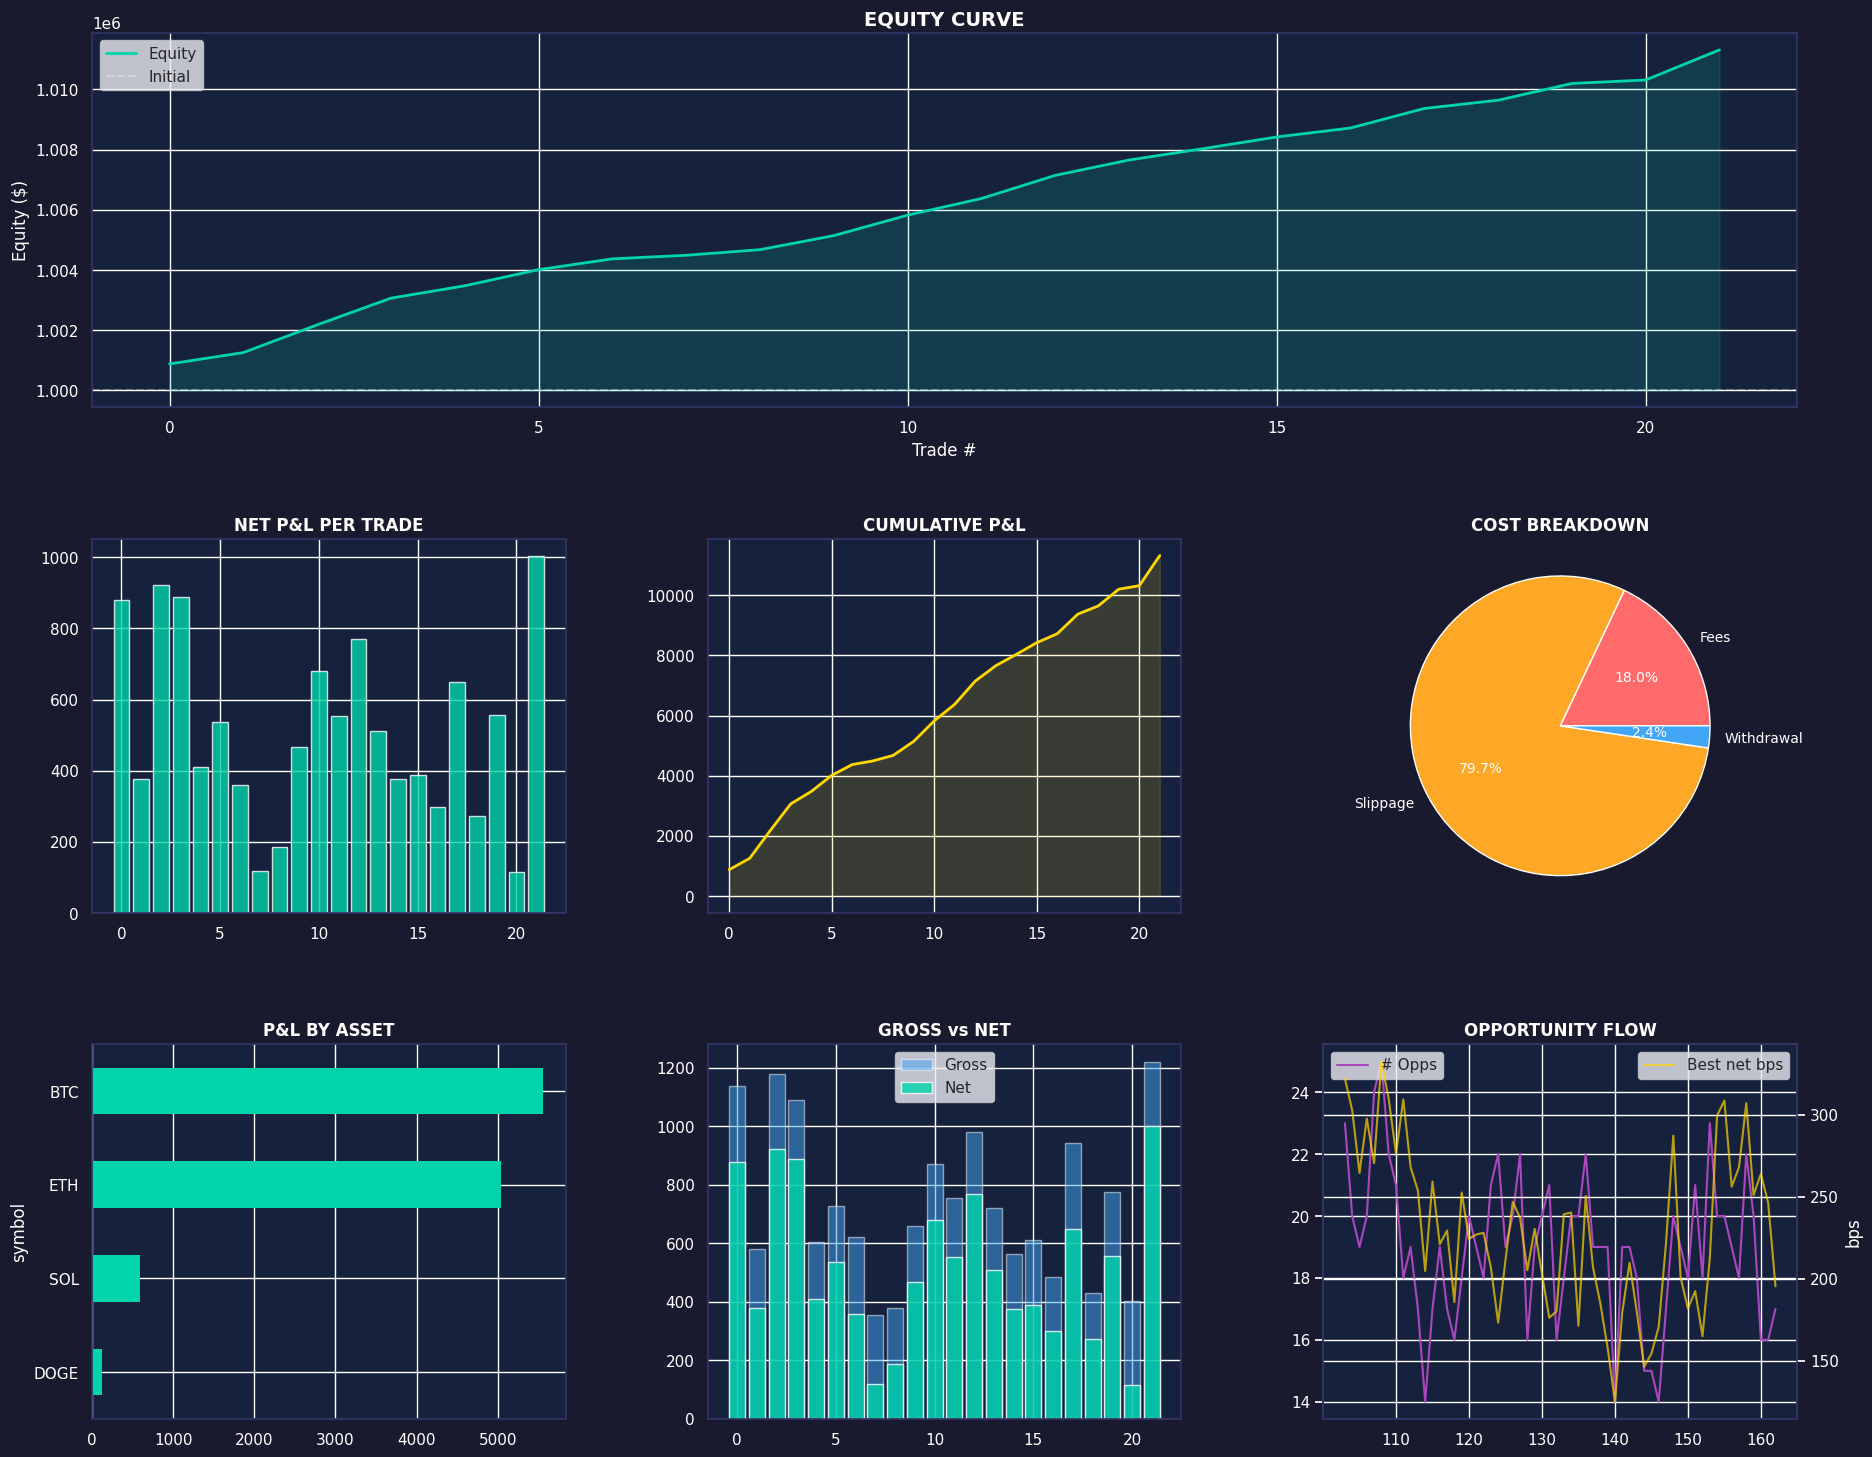

✅ Dashboard rendered


In [36]:
# ══════════════════════════════════════════════════════════════════════
# CELL 9: P&L ANALYTICS & PERFORMANCE DASHBOARD
# ══════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(22, 18))
gs = gridspec.GridSpec(3, 3, hspace=0.35, wspace=0.30)
dark_bg, panel_bg = '#1a1a2e', '#16213e'

# ── 1. Equity Curve ──
ax1 = fig.add_subplot(gs[0, :])
if portfolio.equity_curve:
    ec = portfolio.equity_curve
    ax1.plot(ec, color='#00d4aa', lw=2, label='Equity')
    ax1.axhline(portfolio.initial_capital, color='white',
                ls='--', alpha=0.3, label='Initial')
    ax1.fill_between(range(len(ec)), portfolio.initial_capital, ec,
                     where=[e >= portfolio.initial_capital for e in ec],
                     alpha=0.15, color='#00d4aa')
    ax1.fill_between(range(len(ec)), portfolio.initial_capital, ec,
                     where=[e < portfolio.initial_capital for e in ec],
                     alpha=0.15, color='#ff4444')
ax1.set_title('EQUITY CURVE', fontsize=14, fontweight='bold', color='white')
ax1.set_xlabel('Trade #'); ax1.set_ylabel('Equity ($)'); ax1.legend()

# ── 2. Per-Trade P&L ──
ax2 = fig.add_subplot(gs[1, 0])
if portfolio.pnl_history:
    pnls = [t['net_pnl'] for t in portfolio.pnl_history]
    cols = ['#00d4aa' if p >= 0 else '#ff4444' for p in pnls]
    ax2.bar(range(len(pnls)), pnls, color=cols, alpha=0.8)
    ax2.axhline(0, color='white', lw=0.5, alpha=0.5)
ax2.set_title('NET P&L PER TRADE', fontsize=12, fontweight='bold', color='white')

# ── 3. Cumulative P&L ──
ax3 = fig.add_subplot(gs[1, 1])
if portfolio.pnl_history:
    cum = [t['cumulative_pnl'] for t in portfolio.pnl_history]
    ax3.plot(cum, color='#ffd700', lw=2)
    ax3.fill_between(range(len(cum)), 0, cum,
                     where=[c >= 0 for c in cum], alpha=0.15, color='#ffd700')
    ax3.fill_between(range(len(cum)), 0, cum,
                     where=[c < 0 for c in cum], alpha=0.15, color='#ff4444')
    ax3.axhline(0, color='white', lw=0.5, alpha=0.5)
ax3.set_title('CUMULATIVE P&L', fontsize=12, fontweight='bold', color='white')

# ── 4. Cost Breakdown ──
ax4 = fig.add_subplot(gs[1, 2])
cv = [portfolio.total_fees_paid, portfolio.total_slippage_cost,
      portfolio.total_withdrawal_costs]
if sum(cv) > 0:
    ax4.pie(cv, labels=['Fees', 'Slippage', 'Withdrawal'],
            autopct='%1.1f%%', colors=['#ff6b6b', '#ffa726', '#42a5f5'],
            textprops={'color': 'white', 'fontsize': 10})
else:
    ax4.text(0.5, 0.5, 'No costs', ha='center', color='white', fontsize=12)
ax4.set_title('COST BREAKDOWN', fontsize=12, fontweight='bold', color='white')

# ── 5. P&L by Asset ──
ax5 = fig.add_subplot(gs[2, 0])
if portfolio.pnl_history:
    df = pd.DataFrame(portfolio.pnl_history)
    if 'symbol' in df.columns:
        ap = df.groupby('symbol')['net_pnl'].sum().sort_values()
        ap.plot(kind='barh', ax=ax5, edgecolor='none',
                color=['#00d4aa' if v >= 0 else '#ff4444' for v in ap])
ax5.set_title('P&L BY ASSET', fontsize=12, fontweight='bold', color='white')

# ── 6. Gross vs Net ──
ax6 = fig.add_subplot(gs[2, 1])
if portfolio.pnl_history:
    g = [t['gross_pnl'] for t in portfolio.pnl_history]
    n = [t['net_pnl'] for t in portfolio.pnl_history]
    x = range(len(g))
    ax6.bar(x, g, alpha=0.5, color='#42a5f5', label='Gross')
    ax6.bar(x, n, alpha=0.8, color='#00d4aa', label='Net')
    ax6.axhline(0, color='white', lw=0.5, alpha=0.5); ax6.legend()
ax6.set_title('GROSS vs NET', fontsize=12, fontweight='bold', color='white')

# ── 7. Opportunity Landscape ──
ax7 = fig.add_subplot(gs[2, 2])
if all_opp_stats:
    od = pd.DataFrame(all_opp_stats)
    ax7.plot(od['tick'], od['count'], color='#ab47bc', lw=1.5, label='# Opps')
    ax7r = ax7.twinx()
    ax7r.plot(od['tick'], od['best_spread'], color='#ffd700', lw=1.5,
              alpha=0.7, label='Best net bps')
    ax7r.set_ylabel('bps', color='#ffd700')
    ax7.legend(loc='upper left'); ax7r.legend(loc='upper right')
ax7.set_title('OPPORTUNITY FLOW', fontsize=12, fontweight='bold', color='white')

# Styling
fig.patch.set_facecolor(dark_bg)
for ax in fig.get_axes():
    ax.set_facecolor(panel_bg)
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    for s in ax.spines.values():
        s.set_color('#333366')

plt.savefig('dashboard.png', dpi=150, bbox_inches='tight',
            facecolor=dark_bg)
plt.show()
print("✅ Dashboard rendered")

##10.AGENT INSTROSPECTION AND STRATEGY REVIEW

###10.1.OVERVIEW

**Cell 10 — Agent post-mortem: structured reflection and policy iteration**

The final cell closes the learning loop by turning the session into a review artifact. It summarizes key metrics such as win rate, profitability ratios, and risk-adjusted performance proxies, then feeds a structured session snapshot back into a language model to generate an introspective post-mortem. The goal is not to treat the model’s narrative as truth, but to use it as a design tool. A good post-mortem highlights patterns consistent with the quantitative diagnostics: for example, that losses occurred when trading low net edges, or that cost drag dominated gross profits. It may suggest prompt or policy changes, such as raising minimum edge thresholds, trading less frequently, or emphasizing liquidity and reliability. This cell therefore frames the notebook as an iterative research harness. You run a session, diagnose failure modes, adjust the policy or constraints, and run again. The post-mortem becomes a structured companion to the charts, encouraging principled iteration rather than ad hoc tinkering.


###10.2.CODE AND IMPLEMENTATION

In [37]:
# ══════════════════════════════════════════════════════════════════════
# CELL 10: AGENT INTROSPECTION & STRATEGY REVIEW
# ══════════════════════════════════════════════════════════════════════

print("═" * 80)
print("  🔬  POST-MORTEM ANALYSIS")
print("═" * 80)

# ── Compute advanced metrics ──
stats = {
    'ticks': NUM_TICKS,
    'trades': portfolio.total_trades,
    'wins': portfolio.winning_trades,
    'losses': portfolio.losing_trades,
    'win_rate': round(portfolio.winning_trades / max(portfolio.total_trades, 1), 3),
    'realized_pnl': round(portfolio.realized_pnl, 2),
    'fees': round(portfolio.total_fees_paid, 2),
    'slippage': round(portfolio.total_slippage_cost, 2),
    'withdrawal_costs': round(portfolio.total_withdrawal_costs, 2),
    'volume': round(portfolio.total_volume, 0),
    'max_dd_pct': round(portfolio.max_drawdown * 100, 3),
    'equity': round(portfolio.cash, 2),
    'roi_pct': round((portfolio.cash - portfolio.initial_capital)
                     / portfolio.initial_capital * 100, 4),
    'profit_factor': None,
    'sharpe': None,
}

if portfolio.pnl_history:
    pdf = pd.DataFrame(portfolio.pnl_history)
    w = pdf[pdf['net_pnl'] > 0]['net_pnl'].sum()
    l = abs(pdf[pdf['net_pnl'] < 0]['net_pnl'].sum())
    stats['profit_factor'] = round(w / max(l, 0.01), 2)
    if len(pdf) > 1:
        s = pdf['net_pnl']
        stats['sharpe'] = round(
            s.mean() / max(s.std(), 0.001)
            * np.sqrt(252 * 24 * 60 / AGENT_INTERVAL), 2)

# ── GPT-5.2 self-review ──
session_data = {
    'stats': stats,
    'trade_log': portfolio.pnl_history[-20:],
    'agent_reasoning': [d.get('reasoning', '')[:200]
                        for d in all_decisions[:5]],
}

try:
    review = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": (
                "You are reviewing your own trading session. Analyze:\n"
                "1. Performance — profitable after costs?\n"
                "2. Cost analysis — biggest drag?\n"
                "3. Strategy critique — winning vs losing patterns?\n"
                "4. Risk — drawdown acceptable?\n"
                "5. Recommendations — specific improvements.\n"
                "Be quantitative. Reference the numbers.")},
            {"role": "user", "content": json.dumps(session_data, default=str)},
        ],
        temperature=0.5, max_tokens=2000,
    )
    print(f"\n🧠 GPT-5.2 SELF-REVIEW:\n")
    print(review.choices[0].message.content)
except Exception as e:
    print(f"\n⚠️  Review unavailable: {e}")

# ── Metrics table ──
print("\n" + "═" * 80)
print("  📋  DETAILED METRICS")
print("═" * 80)

rows = [
    ("Final Equity",           f"${stats['equity']:>14,.2f}"),
    ("Realized P&L",           f"${stats['realized_pnl']:>14,.2f}"),
    ("ROI",                    f"{stats['roi_pct']:>14.4f}%"),
    ("", ""),
    ("Total Trades",           f"{stats['trades']:>14d}"),
    ("Win Rate",               f"{stats['win_rate']:>14.1%}"),
    ("Profit Factor",          f"{stats['profit_factor'] or 'N/A':>14}"),
    ("Sharpe (ann.)",          f"{stats['sharpe'] or 'N/A':>14}"),
    ("", ""),
    ("Volume",                 f"${stats['volume']:>14,.0f}"),
    ("Fees",                   f"${stats['fees']:>14,.2f}"),
    ("Slippage",               f"${stats['slippage']:>14,.2f}"),
    ("Withdrawal Costs",       f"${stats['withdrawal_costs']:>14,.2f}"),
    ("All-in Cost (bps)",      f"{(stats['fees']+stats['slippage']+stats['withdrawal_costs'])/max(stats['volume'],1)*10000:>14.1f}"),
    ("", ""),
    ("Max Drawdown",           f"{stats['max_dd_pct']:>14.3f}%"),
    ("Agent API Calls",        f"{agent.total_api_calls:>14d}"),
    ("Tokens Used",            f"{agent.total_tokens:>14,d}"),
]

for label, val in rows:
    if not label:
        print(f"  {'─'*45}")
    else:
        print(f"  {label:<26s} {val}")

# ── Trade log ──
if portfolio.pnl_history:
    print(f"\n\n📊 Last 10 trades:")
    tdf = pd.DataFrame(portfolio.pnl_history)
    cols = [c for c in ['trade_id','symbol','gross_pnl','fees',
                         'slippage','withdrawal','net_pnl',
                         'cumulative_pnl'] if c in tdf.columns]
    print(tdf[cols].tail(10).to_string(index=False))

print("\n" + "═" * 80)
print("  ✅  COMPLETE — All objects (engine, portfolio, agent) available")
print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
  🔬  POST-MORTEM ANALYSIS
════════════════════════════════════════════════════════════════════════════════

🧠 GPT-5.2 SELF-REVIEW:

### Performance Analysis

1. **Profitability**: The session was profitable, with a realized PnL of $11,318.08 after costs, including fees, slippage, and withdrawals. This indicates a successful trading period.
2. **ROI**: The return on investment (ROI) was 1.1318%, which is a decent return given the trading volume of $1,100,000.00.
3. **Win Rate**: The win rate was 100%, with all 22 trades resulting in a profit, underscoring the effectiveness of the strategy.

### Cost Analysis

1. **Biggest Cost**: Slippage was the most significant cost, amounting to $18,665.61, which is considerably higher than the fees ($4,210.00) and withdrawal costs ($554.00).
2. **Impact of Costs**: The total costs (fees, slippage, and withdrawals) significantly reduced the gross PnL. Managing slippage m

##11.CONCLUSIONS

**Conclusion**

This notebook is best understood as a rigorous thought experiment encoded in runnable form. It takes a phenomenon that traders talk about casually—cross-exchange arbitrage in crypto—and rebuilds it as an accountable system with explicit mechanisms. The result is not a claim about real-world profitability. It is a claim about modeling discipline: if you want to discuss “opportunities,” you must define what counts as an opportunity after fees, slippage, latency, and liquidity constraints. If you want to discuss “an agent,” you must define the agent’s information set, its action space, and the guardrails that keep it from behaving like a reckless optimizer. If you want to discuss “performance,” you must produce diagnostics that separate gross edge from net edge, and expectation from realization. That is what this notebook provides: a full, closed loop where each stage is legible.

The most valuable outcome is not the final equity curve. The valuable outcome is the set of failure modes you can observe. In the synthetic market, spreads can appear large and still be untradeable once depth is considered. They can appear tradable and still collapse under latency drift. They can survive latency and still be erased by the combined fee load of two venues plus the friction penalty associated with moving value across venues. These are not bugs in the notebook; they are the point. In real markets, most “arbitrage” is not a mathematical identity. It is an engineering problem constrained by time, liquidity, and operational reliability. The notebook makes that reality unavoidable by forcing every candidate idea through an execution model that can reject, partially fill, or degrade the trade. The mismatch between pre-trade estimates and post-trade outcomes becomes a measurable object rather than a vague complaint.

Equally important is how the notebook frames risk. Many simulated trading setups focus on signal generation and treat risk as a single parameter. Here, risk is a gate. A trade is not “good” because it is profitable in expectation; it is good because it fits within a bounded loss regime. The drawdown constraint, daily loss cap, minimum edge threshold, and position sizing limits are all blunt instruments, but they enforce a professional intuition: you do not get infinite tries. The role of the agent is therefore not to maximize raw expected value each tick; it is to choose a small number of actions that keep the system inside a survivable envelope while still exploiting high-quality edges. That framing shifts the discussion from opportunism to robustness. A strategy that cannot remain stable under modest stress constraints is not ready for more realism; it is ready for redesign.

The agentic component is intentionally constrained, and that constraint is a feature. The agent does not run code, does not inspect hidden state, and does not “discover” opportunities from raw data. It receives structured candidates that already encode cost estimates, sizes, and confidence heuristics. In other words, the notebook decomposes the problem: classical code generates opportunities and enforces safety constraints; the agent contributes discretion—how many trades to take, which ones to prioritize, and how aggressively to size within allowed ranges. This decomposition is pedagogically strong because it mirrors how a real system would be governed: deterministic components should handle accounting, constraints, and computation; discretionary components should be bounded, inspectable, and replaceable. If you want to test whether an LLM adds value, you should not let it rewrite the world; you should let it operate inside a constrained policy role.

From that perspective, the notebook functions as a template for iterative experimentation. You can vary the market regime: increase jump frequency, reduce liquidity, raise fees, increase latency, or reduce exchange uptime and observe whether the same policy remains coherent. You can vary the opportunity model: change the slippage estimation bias, alter withdrawal cost treatment, or introduce explicit settlement delay and see how sensitive net performance is. You can vary the agent policy: tighten confidence thresholds, reduce trade frequency, enforce stronger diversification, or instruct stronger aversion to thin edges. Each change reveals something different: whether the performance is driven by robust edge capture or by favorable assumptions.

One of the most instructive lessons is that “arbitrage” is a spectrum. At one extreme is true riskless arbitrage, which largely disappears as markets mature and infrastructure improves. At the other extreme is what many strategies call arbitrage but which is really short-horizon speculative execution: a bet that the spread will not move against you during the latency window, a bet that liquidity will remain, a bet that venue availability will hold, and a bet that your cost estimates are not understated. The notebook encourages this honest interpretation because it makes the fragility visible. When net PnL collapses while gross opportunities appear abundant, the notebook forces you to ask the correct questions: are costs mis-modeled, is the agent chasing noise, is liquidity too thin, or is the environment too adversarial for the current policy?

Finally, the notebook’s diagnostics close the loop in a way that supports learning. The dashboards separate the pieces: how much was earned before costs, how much was lost to fees, slippage, and withdrawal, which assets contributed, and how equity evolved. This is the minimum necessary structure for responsible iteration. Without it, you risk mistaking randomness for skill or cost underestimation for edge. The qualitative post-mortem adds a complementary layer: a narrative that helps you refine prompts and policies, while still being grounded in measurable outcomes. Used carefully, it becomes a tool for design, not self-congratulation.

The right way to leave this notebook is with sharper questions, not with overconfidence. What happens if settlement is modeled explicitly as a time lock that creates inventory risk? How does performance change when exchange balances are not artificially rebalanced and operational constraints become binding? What is the marginal value of the agent compared to a simple deterministic baseline that always takes the top net edge above threshold? Under which regimes does discretion help, and under which does it harm? Those are the questions this notebook is designed to support. It is not an answer to the market; it is an answer to the engineering problem of building an agentic decision loop that is transparent, stressable, and diagnostically rich. If you treat it as a laboratory for policy and mechanism, it will do its job: it will teach you exactly where your assumptions break—and what you would need to control before you ever let a real system touch real capital.
